In [33]:
import fuzzylite as fl

Make fll File
---

In [91]:
def get_fll_file(item,total_value,distance):
    fuz_file = open("fuz_file{}.fll".format(item), "w")
    max_value = max(total_value)
    max_distance = max(distance)
    fll_file =[
    'Engine: Accessible_fertilizers\n',
    '  description:(value,neighborhood)->accessiblity\n',

    '''InputVariable: value
      description: value is defined based on export and production tonnes per country
      enabled: true
      range: 0 {0}
      lock-range: true
      term: high Trapezoid 0 0 {1} {2}
      term: normal Triangle {1} {3} {5}
      term: low Trapezoid {5} {6} {0} {0}\n'''.format(max_value,
                                                    max_value-0.92 *max_value,
                                                    max_value-0.8 *max_value,
                                                    max_value-0.64 *max_value,
                                                    max_value-0.48*max_value,
                                                    max_value-0.16 *max_value,
                                                    max_value-0.08 *max_value                                                
                                                   ),

    '''InputVariable: neighborhood
      description: how far the country is from the specified country
      enabled: true
      range: 0 {0}
      lock-range: true
      term: close Triangle 0 {1} {2}
      term: far Triangle {1} {2} {0}\n'''.format(max_distance,
                                               max_distance-0.33*max_distance,
                                               max_distance - 0.66*max_distance,
                                              ),

    '''OutputVariable: accessible
      description: how accessible the fertilizer is based on value and neighborhood
      enabled: true
      range: 0 {0}
      lock-range: false
      aggregation: Maximum
      defuzzifier: Centroid 100
      default: nan
      lock-previous: false
      term: good Triangle 0 {1} {2}
      term: medium Triangle {1} {2} {3}
      term: bad Triangle {2} {3} {0}\n'''.format(max_value + max_distance,
                                               max_value + max_distance - 0.75*(max_value + max_distance),
                                               max_value + max_distance - 0.5*(max_value + max_distance),
                                               max_value + max_distance -0.25*(max_value + max_distance)
                                              ),


    '''RuleBlock: rules
      description: Mamdani inference
      enabled: true
      conjunction: AlgebraicProduct
      disjunction: AlgebraicSum
      implication: Minimum
      activation: General
      rule: if value is low or neighborhood is far then accessible is bad
      rule: if value is high then accessible is medium
      rule: if value is high or neighborhood is close then accessible is good with 0.500
      rule: if value is high and neighborhood is close then accessible is good'''
    ]

    fuz_file.writelines(fll_file)
    fuz_file.close()


Fitness Function
---

In [ ]:
def fitness(chromosome, country_neighbors,country,fertilizer_name):
    engine ={}
    item = chromosome.keys
    #chromosome = items_sorted_by_production_and_export
    distance_country_neighbors = list(map(lambda c:c-country , country_neighbors))
    get_fll_file(chromosome.keys,chromosome.values,distance_country_neighbors)
    engine.keys(item) = fl.FllImporter().from_file('fuz_file{}.fll'.format(item))
    
    exp_value = engine[item].input_variable("value")
    neighborhood = engine[item].input_variable("neighborhood")
    accessible = engine[item].output_variable("accessible")
    
    exp_value.value = chromosome[fertilizer_name]
    neighborhood.value = country_neighbors[country]
    engine[item].process()
    
    
    return accessible.value

Test Fuzzy system
---

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
engine_file = get_fll_file(2,[1161725752.4499998,302873315.83],[10000,20000])
engine_test = fl.FllImporter().from_file('fuz_file{}.fll'.format(2))

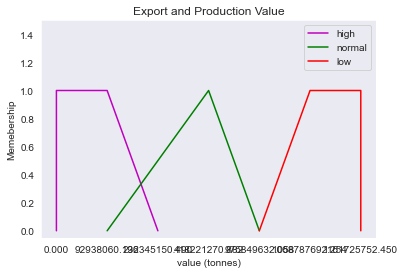

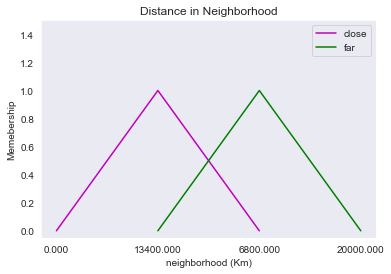

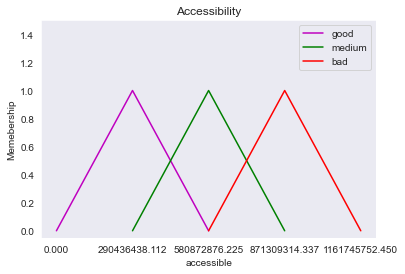

In [95]:
sns.set_style('darkgrid')
value = engine_test.input_variable("value")
neighborhood = engine_test.input_variable("neighborhood")
accessible = engine_test.output_variable("accessible")


y_triangle = [0, 1, 0]  
y_trapezoid = [0, 1, 1, 0]  
colors = ['m-', 'g-', 'r-', 'y-', 'b-', 'c-', ] 

variables = [value, neighborhood, accessible]
for v in variables: 
    t = v.terms
    for i in range(len(t)):  
        term = str(t[i]).split()  
        term_name = term[1]  
        figure = term[2]  
        if figure == "Trapezoid":
            x = [term[3], term[4], term[5], term[6]]
            plt.plot(x, y_trapezoid, colors[i], label=term_name)  
        elif figure == "Triangle":
            x = [term[3], term[4], term[5]]
            plt.plot(x, y_triangle, colors[i], label=term_name)  
        else:
            print("Error")
    if v.name == "value":
        plt.title("Export and Production Value")
        plt.xlabel(v.name + " (tonnes)")
    elif v.name == "neighborhood":
        plt.title("Distance in Neighborhood")
        plt.xlabel(v.name + " (Km)")
    elif v.name == "accessible":
        plt.title("Accessibility")
        plt.xlabel(v.name )
    else:
        plt.title("XX")
        plt.xlabel("xx")
    plt.ylabel("Memebership")
    plt.axis(ymax=1.5)
    plt.grid()
    plt.legend()
    plt.show()

In [103]:
value.value = 120
neighborhood.value = 50000
engine_test.process()

In [104]:
accessible.value

459818968.81970996